In [1]:
import pickle
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
import time
import os.path
import time
from datetime import datetime, timezone
import pytz
from itertools import cycle
from scipy import stats, ndimage
from skimage.transform import hough_line, hough_line_peaks
from skimage.filters import threshold_yen
from functions.HXRSS_tool_plotter_limit import Bragg_plotter_limit  # Crystal model 


## Crystal model setup

In [69]:
colors=['r','w','b','m','c','r','g']

# Model parameters, these should remain unchanged unless the photon energy is above 15 keV where hmax = 6, kmax = 6, lmax = 7.
hmax = 7
kmax = 7
lmax = 8
#dthp = -0.27
#dthy = -0.2
#dthr = -0.295
#alpha = 0.00005
dthp = -0.27
dthy = -0.20
dthr = 0
alpha = 0
en = -11

def dilation(image, n):    
    dilated_image = ndimage.grey_dilation(image, size=(n, n))
    return dilated_image

def erosion(image, n): 
    eroded_image = ndimage.grey_erosion(image, size=(n, n))
    return eroded_image

1
Monochromator 2 image found; 
Machine status file found: roll angle=1.2799 deg 

9200.240096939131
9120.387447962423
9133.979388213776
2
Monochromator 2 image found; 
Machine status file found: roll angle=1.2799 deg 

9200.240096939131
9120.387447962423
9133.979388213776
3
Monochromator 2 image found; 
Machine status file found: roll angle=1.2799 deg 

9034.62368209702
4
Monochromator 2 image found; 
Machine status file found: roll angle=2.4 deg 

9040.774252234514
5
Monochromator 2 image found; 
Machine status file found: roll angle=0.0 deg 

9032.51786778117
6
Monochromator 2 image found; 
Machine status file found: roll angle=-0.5 deg 

9032.238765577185
7
Monochromator 2 image found; 
Machine status file found: roll angle=-0.5 deg 

9032.82569141245
8
Monochromator 2 image found; 
Machine status file found: roll angle=-0.8 deg 

9
Monochromator 2 image found; 
Machine status file found: roll angle=-0.8 deg 

9038.770754599907
10
Monochromator 2 image found; 
Machine status file f

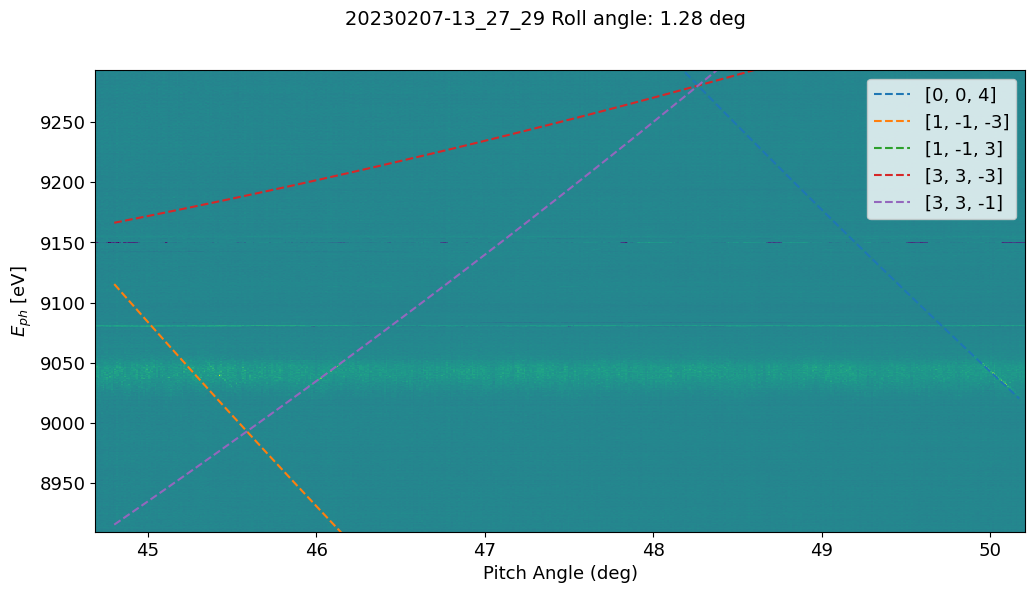

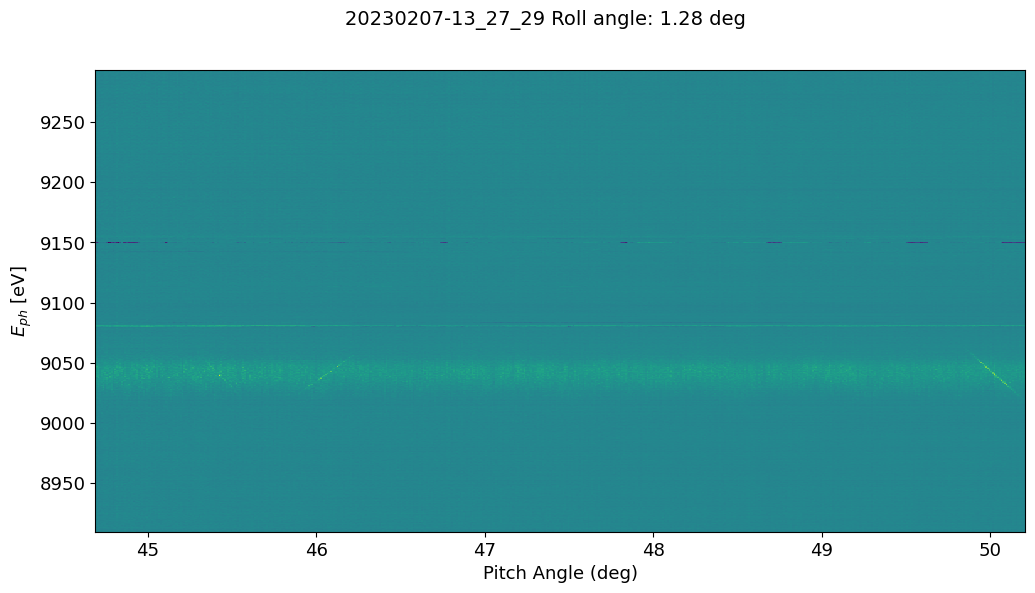

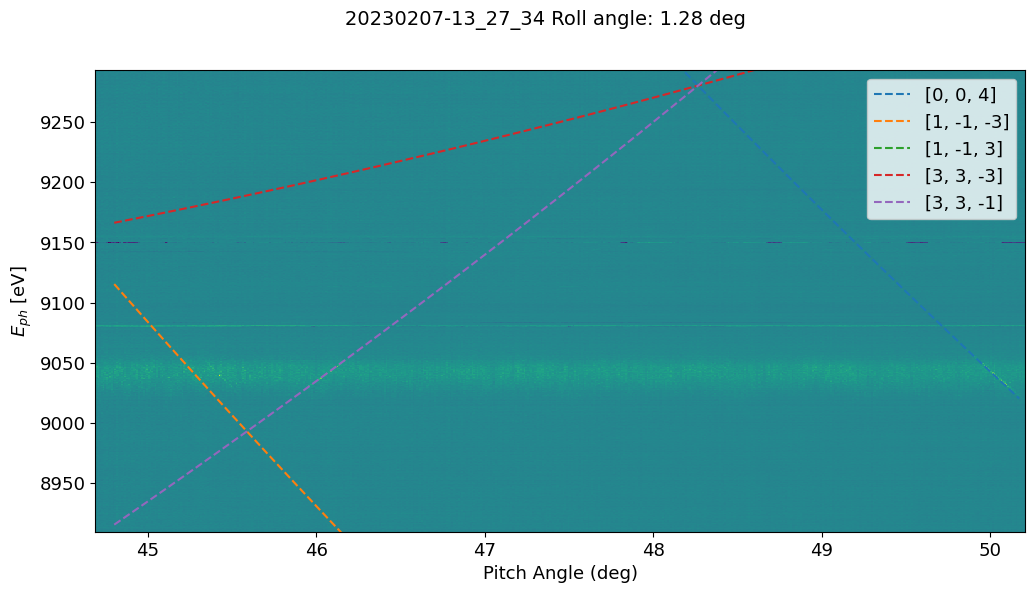

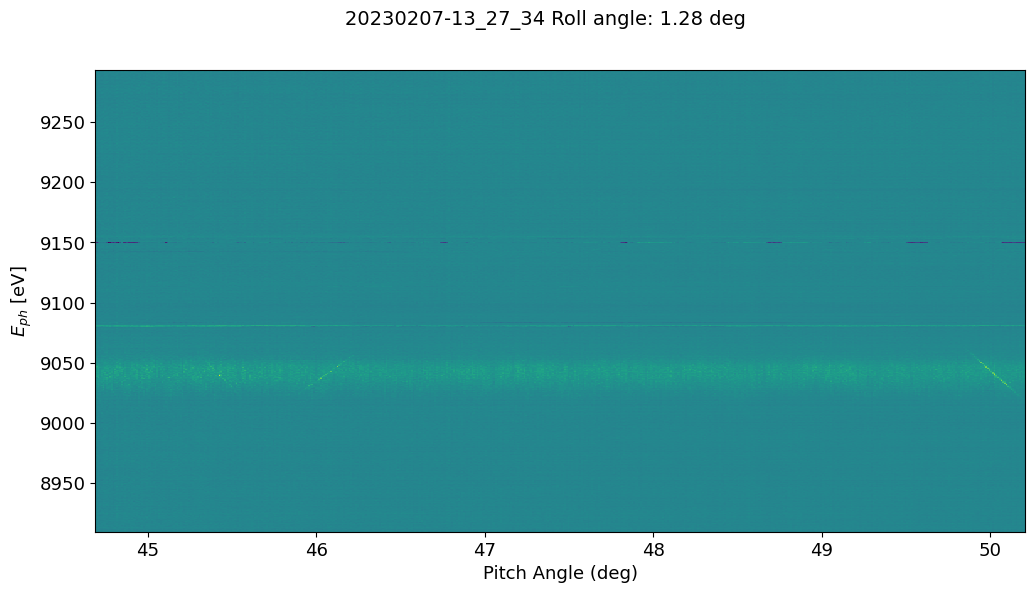

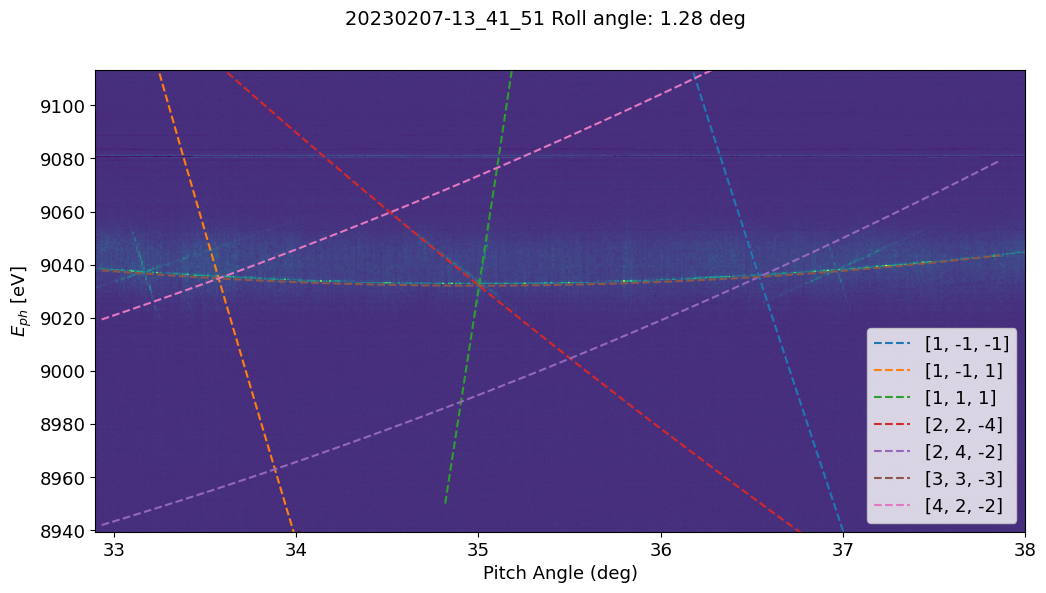

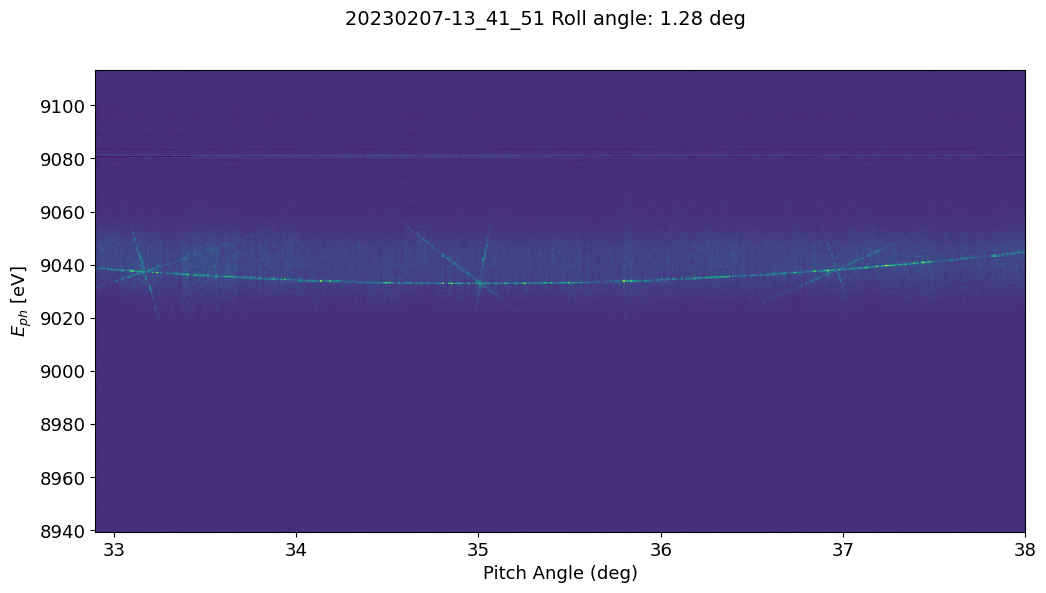

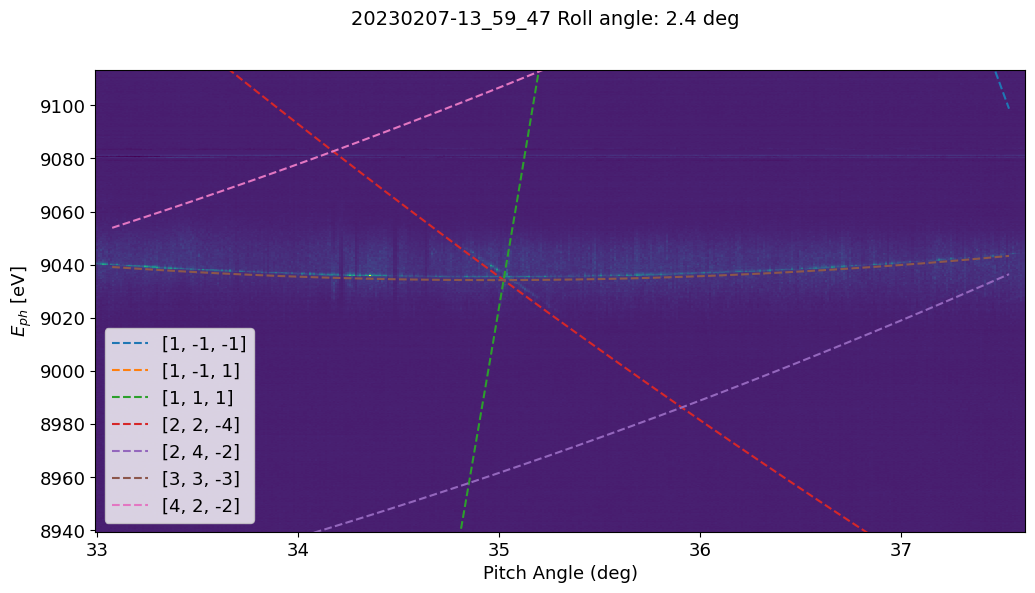

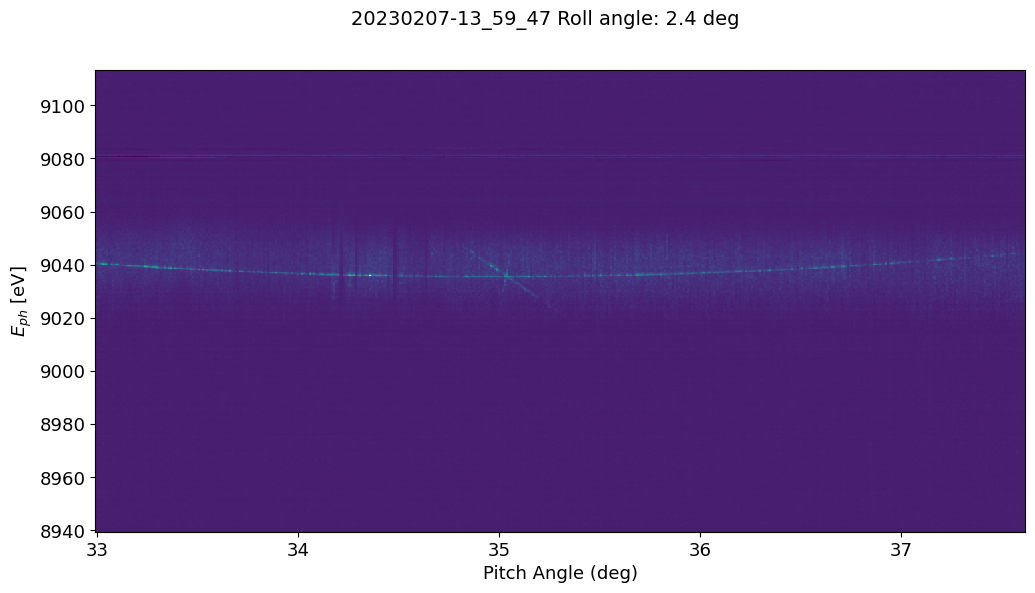

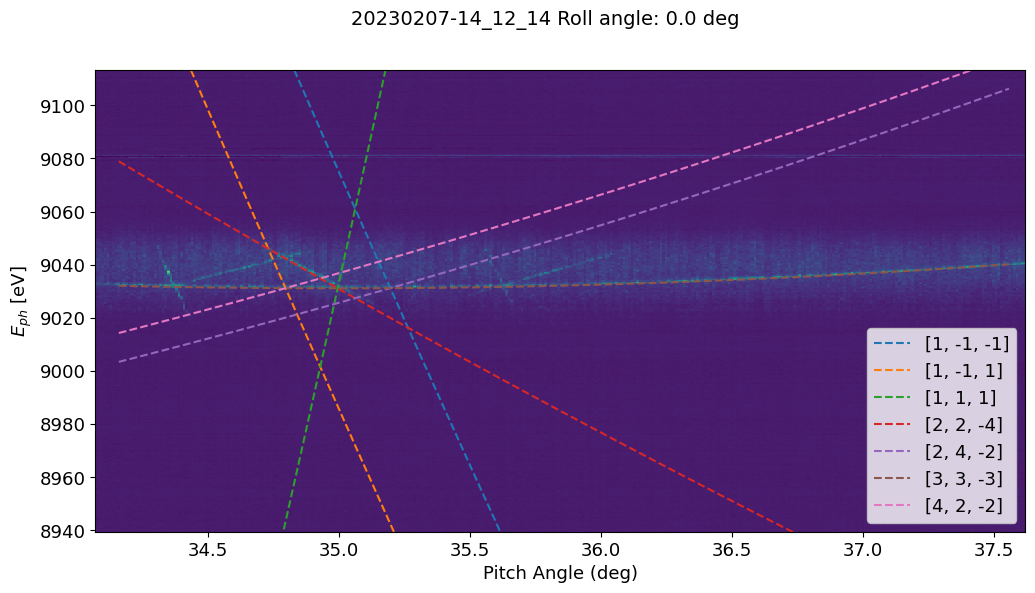

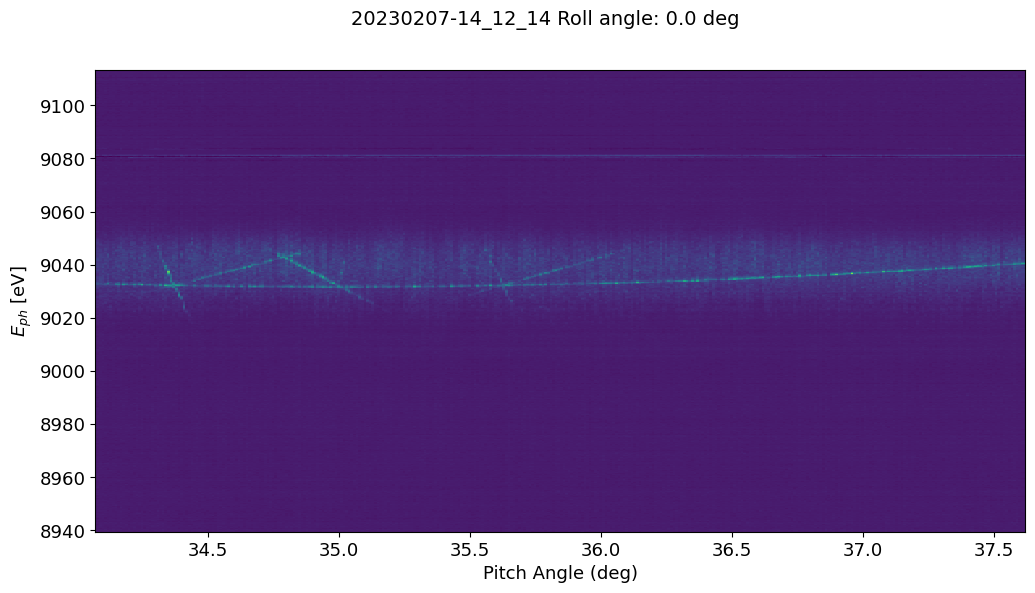

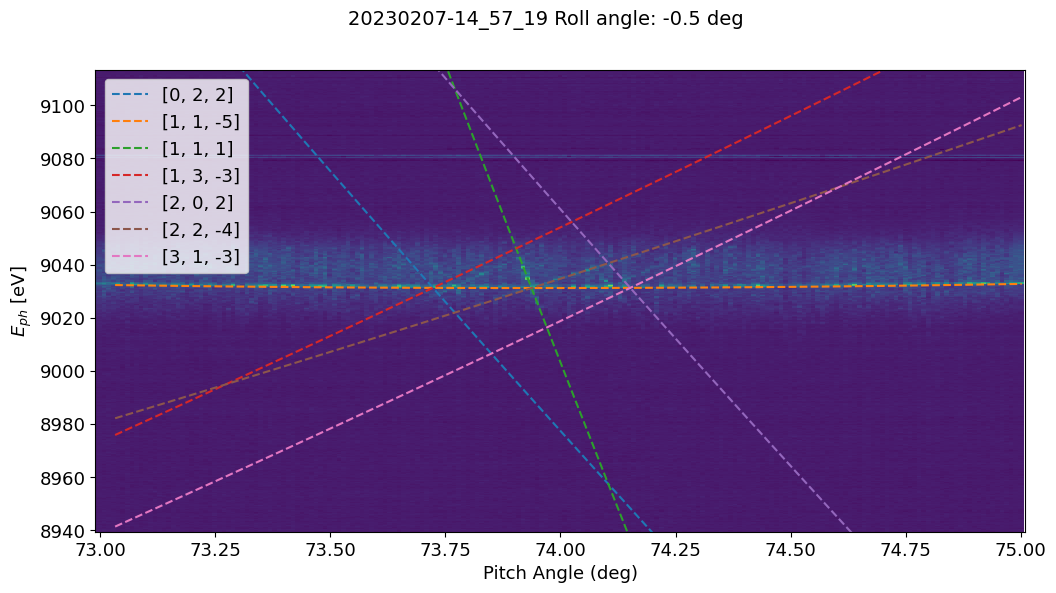

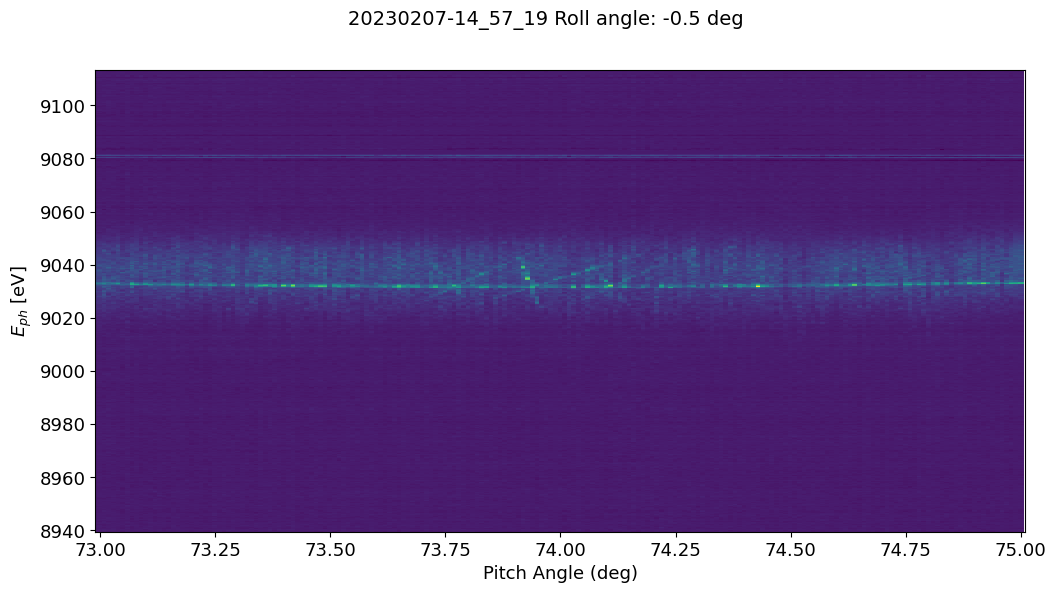

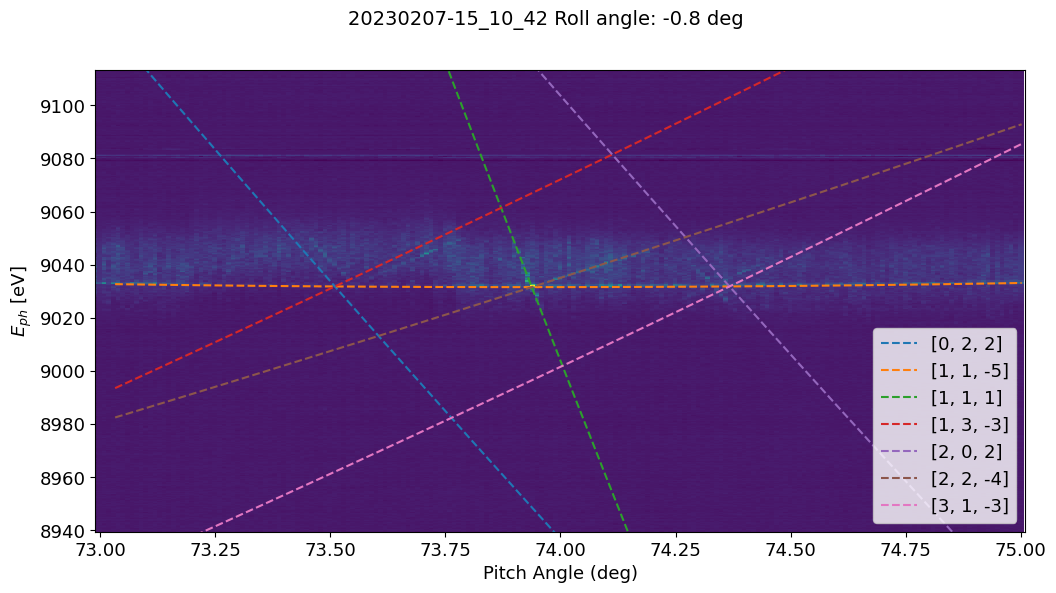

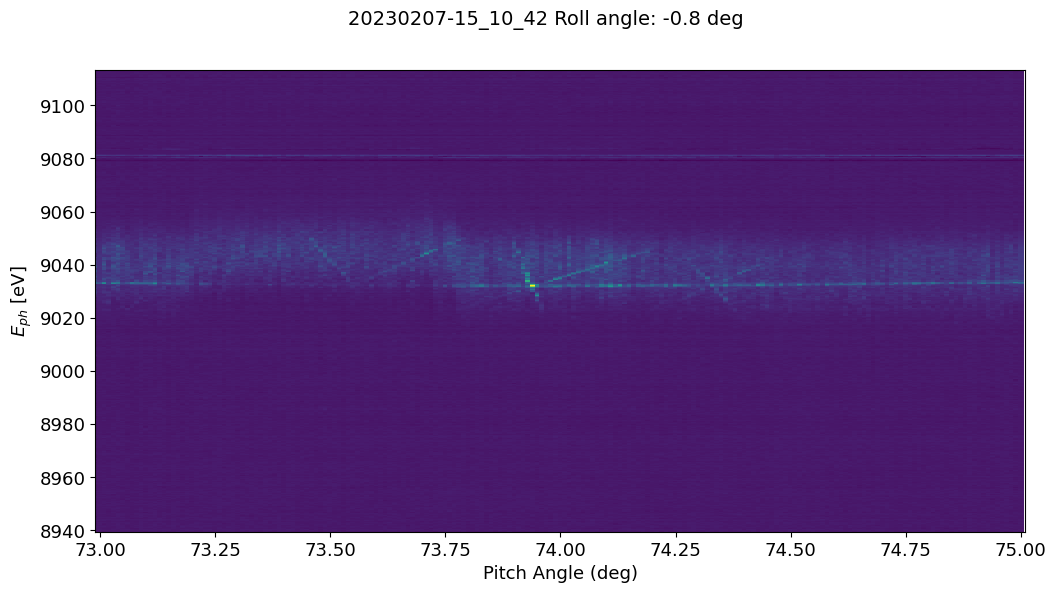

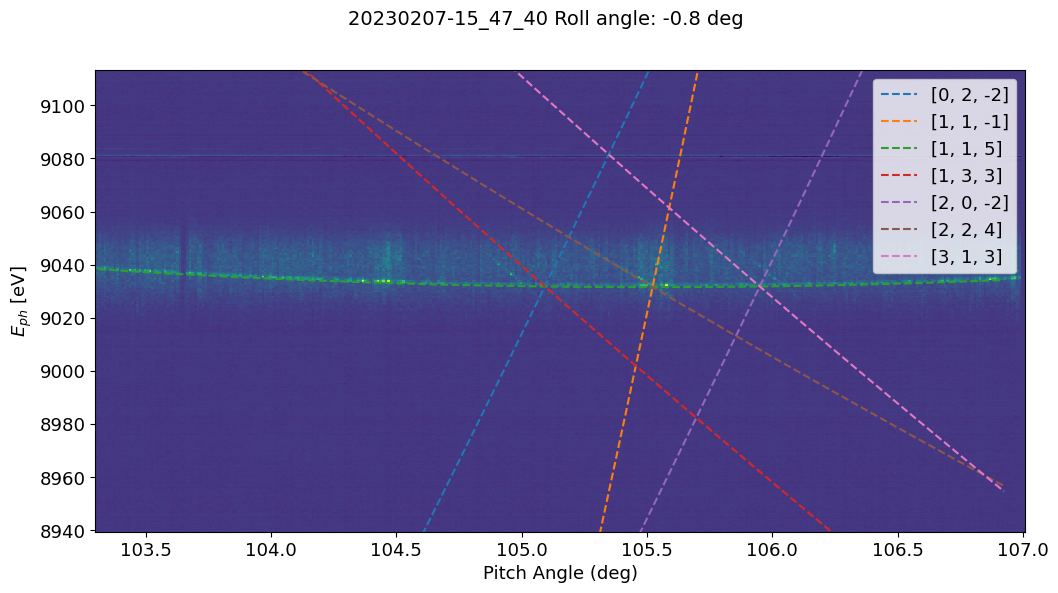

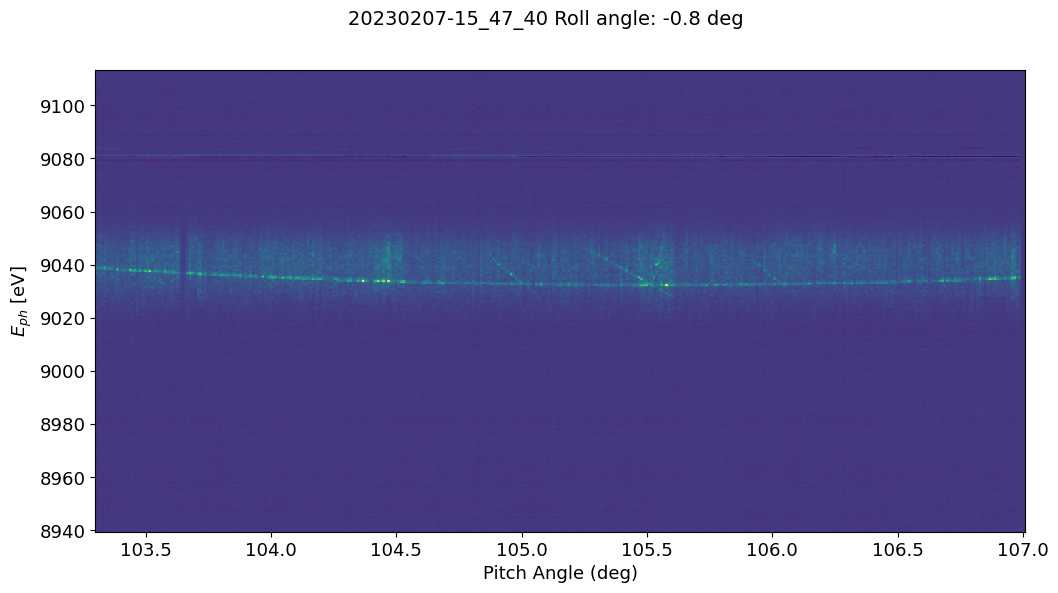

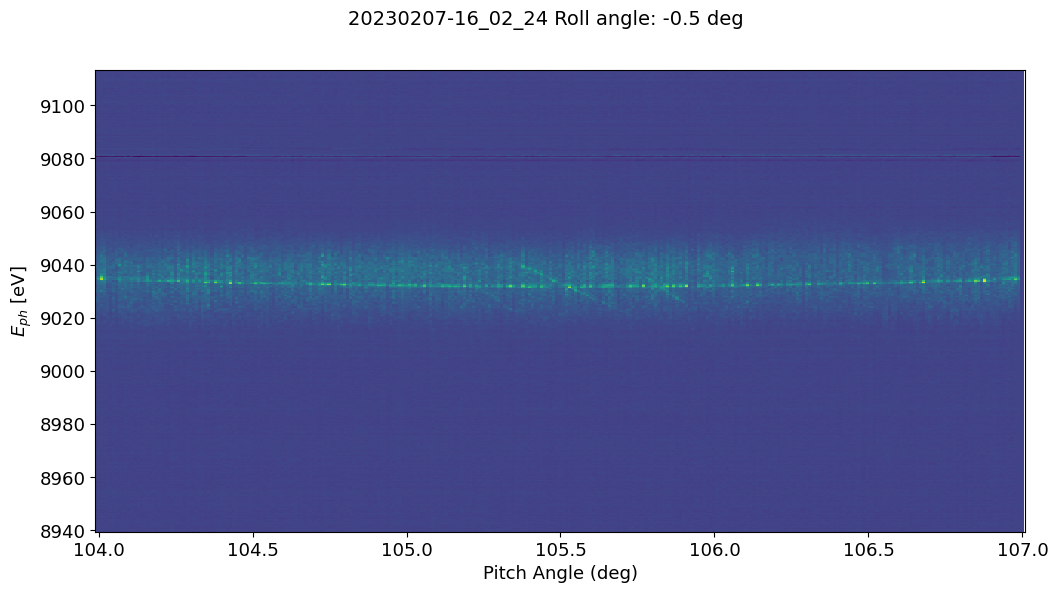

In [70]:
#directory = os.fsencode("./data.nosync/")
directory = r'2023data.nosync/' 
m=0
for file in sorted(os.listdir(directory)):  
    filename = os.fsdecode(file)
    if filename.startswith('20230207') and filename.endswith('cor2d.npz'):
        filepath=os.path.join(directory, file)
        tt = np.load(filepath, allow_pickle=True)
        corr2d = tt['corr2d']
        orig_image = tt['corr2d'].T
        spec_hist = tt['spec_hist']
        doocs_scale = tt['doocs_scale']
        np_phen = tt['phen_scale']+en
        doocs_vals_hist = tt['doocs_vals_hist']
        doocs_label = tt['doocs_channel']
        date_raw=filename[ 0 : 17 ]
        date_time_obj = datetime.strptime(date_raw, '%Y%m%d-%H_%M_%S')
        # check if the image corresponds to a crystal pitch angle scan. MONOPA 
        if "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2/ANGLE" in doocs_label or "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2/ANGLE" in doocs_label:
            date_raw=filename[ 0 : 17 ]
            date_time_obj = datetime.strptime(date_raw, '%Y%m%d-%H_%M_%S') #strip date from image filename
            m=m+1
            print(m)
            # Search for corresponding roll angle from the status file or the database pickle file.
            if "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2/ANGLE" in doocs_label: 
                mono_no_pitch = 1
                try:
                    filedata = np.loadtxt(
                        filepath+'_status.txt', dtype='str', delimiter=',', skiprows=1)
                    ra_pos = np.where(
                        filedata == 'XFEL.FEL/UNDULATOR.SASE2/MONORA.2252.SA2/ANGLE')
                    ra_row = ra_pos[0][0]
                    roll_angle = float(filedata[ra_row][1])
                    print('Monochromator 1 image found; \nMachine status file found: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                except:
                    try:
                        berlin = pytz.timezone('Europe/Berlin')
                        df_db['date_full'] = pd.to_datetime(df_db['date_full'], utc=True)
                        df_db['date_full'] = df_db['date_full'].dt.tz_convert("Europe/Paris")
                        dt = date_time_obj
                        dt = dt.replace(tzinfo=berlin)
                        roll = df_db['roll_angle'].loc[(df_db['date_full'] == nearest(df_db['date_full'], dt)) ]
                        roll_angle = float(roll.iloc[0])
                        print('Monochromator 1 image found; from database: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                    except:
                        roll_angle = 1
                        print('Monochromator 1 image found; Default roll angle set (1 deg).')
            elif "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2/ANGLE" in doocs_label:
                mono_no_pitch = 2
                try:
                    filedata = np.loadtxt(
                        filepath+'_status.txt', dtype='str', delimiter=',', skiprows=1)
                    ra_pos = np.where(
                        filedata == 'XFEL.FEL/UNDULATOR.SASE2/MONORA.2307.SA2/ANGLE')
                    ra_row = ra_pos[0][0]
                    roll_angle = float(filedata[ra_row][1])
                    print('Monochromator 2 image found; \nMachine status file found: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                except:
                    try:
                        berlin = pytz.timezone('Europe/Berlin')
                        df_db['date_full'] = pd.to_datetime(df_db['date_full'], utc=True)
                        df_db['date_full'] = df_db['date_full'].dt.tz_convert("Europe/Paris")
                        dt = date_time_obj
                        dt = dt.replace(tzinfo=berlin)
                        roll = df_db['roll_angle'].loc[(df_db['date_full'] == nearest(df_db['date_full'], dt)) ]
                        roll_angle = float(roll.iloc[0])
                        print('Monochromator 2 image found; from database: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                    except:
                        roll_angle = 1
                        print('Monochromator 2 image found; Default roll angle set (1 deg).')
            else: 
                mono_no_pitch = 0
                print('No roll angle')

        if len(doocs_scale) != len(orig_image):
            np_doocs=doocs_scale[:-1]
        else:
            np_doocs=doocs_scale
            
        phen_list, p_angle_list, gid_list, linestyle_list, color_list = Bragg_plotter_limit(hmax, kmax, lmax, dthp, dthy, dthr, alpha, roll_angle, doocs_scale[0]-1, doocs_scale[-1]+1, 50)
        
        phen_res=np_phen[2]-np_phen[1]
        angle_res_p=np_doocs[2]-np_doocs[1]
        
        # Original image plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(date_raw+' Roll angle: '+str(np.round(roll_angle,3))+' deg', fontsize=14)
        

        plot = ax.pcolormesh(np_doocs, np_phen, orig_image, cmap='viridis', shading='auto')
        for phen, pangle, gid in zip(phen_list, p_angle_list, gid_list):
            ph_axis, pa_axis = [], []
            for ph_value, pa_value in zip(phen, pangle):
                # Only keep photon energies within a close range of the spectrometer image range
                if ph_value > np_phen[0]-50 and ph_value < np_phen[-1]+50 and pa_value >= min(doocs_scale) and pa_value <= max(doocs_scale):
                    ph_axis.append(ph_value)
                    pa_axis.append(pa_value)
            if ph_axis == []:
                pass
            else:
                plt.plot(pa_axis, ph_axis, '--', label=gid)
                #ax[1].plot(pa_axis, ph_axis, '-.', label=gid)
        ax.set_xlabel('Pitch Angle (deg)')
        ax.set_ylabel(r'$E_{ph}$ [eV]')
        plt.rcParams.update({'font.size': 13})
        ax.set_ylim(np_phen[0], np_phen[-1])
        ax.set_xlim(doocs_scale[0], doocs_scale[-1])
        ax.legend(loc='best')
        # calibrated model plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(date_raw+' Roll angle: '+str(np.round(roll_angle,3))+' deg', fontsize=14)
        plot = ax.pcolormesh(np_doocs, np_phen, orig_image, cmap='viridis', shading='auto')
        ax.set_xlabel('Pitch Angle (deg)')
        ax.set_ylabel(r'$E_{ph}$ [eV]')
        plt.rcParams.update({'font.size': 13})
        ax.set_ylim(np_phen[0], np_phen[-1])
        ax.set_xlim(doocs_scale[0], doocs_scale[-1])
        corr2d[corr2d < 0] = 0  # all values below 0 threshold are set to 0
        thresh = threshold_yen(orig_image, nbins=256)
        binary = orig_image > thresh
        processed_image = binary
        processed_image = dilation(processed_image, 2)
        processed_image = erosion(processed_image, 2)
    
        df = pd.DataFrame(data=processed_image.T).astype(int)
        df_scale = pd.DataFrame(data=np_doocs)
        df_scale.columns = ['parameter']
        df_phen = pd.DataFrame(data=np_phen)
        df_phen.columns = ['value']
        df_phen = df_phen.T
        df = pd.concat([df, df_phen], axis=0)
        df.columns = df.iloc[-1]
        df.drop(df.tail(1).index,inplace=True)
        df=df.join(df_scale, lsuffix='caller', rsuffix='other')
        df.set_index('parameter', inplace=True)
        df1 = df.stack().reset_index()
        #set column names
        df1.columns = ['Parameter','Energy','Correlation']
        df2 = df1[df1['Correlation'] != False]
        df2=df2.drop(columns=['Correlation'])
        # Classic straight-line Hough transform
        # Set a precision of 0.5 degree.
        tested_angles = np.linspace(-np.pi/2, np.pi/2, 360, endpoint=False)
        h, theta, d = hough_line(processed_image, theta=tested_angles) 
    
        emp_list, pitch_angle_list, dist_list = hough_line_peaks(h, theta, d, num_peaks=5, min_distance=30, min_angle=30)
        for pitch_angle, dist in zip(pitch_angle_list, dist_list):
            (x0, y0) = dist * np.array([np.cos(pitch_angle), np.sin(pitch_angle)])
            y_pix = ((dist-(((np_doocs-np_doocs[0])/angle_res_p)*np.cos(pitch_angle)))/np.sin(pitch_angle))
            y=min(np_phen)+(y_pix*phen_res)
                #print('x0=', round(x0, 3),' y0=', round(y0, 3), ' angle=', round(angle, 3), ' r=', round(dist, 3), 'y_0', round(y[0], 3))
            min_pangle=min(np_doocs)
            max_pangle=max(np_doocs)
            rho_p = dist
                
            pitch_angle_range = np.linspace(min_pangle, max_pangle, 10)
            
            y_pitch_pix = ((rho_p-(((pitch_angle_range-min_pangle) /
                            angle_res_p)*np.cos(pitch_angle)))/np.sin(pitch_angle))
            y_pitch = min(np_phen) + (y_pitch_pix*phen_res)
                # Calculate slope and intercept
            y_intercept = min(np_phen) + (rho_p*phen_res/np.sin(pitch_angle))+(
                    min_pangle*phen_res*np.cos(pitch_angle)/(angle_res_p*np.sin(pitch_angle)))
            slope = -(phen_res*np.cos(pitch_angle)/(angle_res_p*np.sin(pitch_angle)))
                # Inverse calculation of the pitch angle based on the energy range of the spectrometer data
            min_phen = min(df2['Energy'])
            max_phen = max(df2['Energy'])
            pa_1 = (min_phen-y_intercept)/slope
            pa_2 = (max_phen-y_intercept)/slope
                # Assign max or min angle status based on the polarity of the slope
            if pa_1 < pa_2:
                if pa_1 < min_pangle:
                    pa_1 = min_pangle
                    min_phen = (pa_1*slope)+y_intercept
                if pa_2 > max_pangle:
                    pa_2 = max_pangle
                    max_phen = (pa_2*slope)+y_intercept
                min_line_pangle = pa_1
                max_line_pangle = pa_2
                    
            else:
                if pa_1 > max_pangle:
                    pa_1 = max_pangle
                    max_phen = (pa_1*slope)+y_intercept
                if pa_2 < min_pangle:
                    pa_2 = min_pangle
                    min_phen = (pa_2*slope)+y_intercept
                    print(min_phen)
                min_line_pangle = pa_2
                max_line_pangle = pa_1
                    
            if min_pangle > min_line_pangle:
                min_line_pangle=min_pangle
            if max_pangle < max_line_pangle:
                max_line_pangle=max_pangle
            line_range = np.linspace(min_line_pangle, max_line_pangle, 10)
            phen = (slope*line_range)+y_intercept

            pa_vec = [pa_1, pa_2]
            phen_vec = [min(phen), max(phen)]
            centroid_pa = np.mean(pa_vec)
            centroid_phen = np.mean(phen_vec)
                
                # ignore lines which are horizontal or completely vertical
            if slope <= 10 and slope >= -10:
                continue
                
            if y_intercept == np.inf:
                continue
                
            #ax[1].plot(line_range, (slope*line_range)+y_intercept, color=next(linecolors), linestyle='dashed', linewidth=3)